In [1]:
import torch 

torch.manual_seed(1024)

In [2]:
class Linear:
    # input:(B,in_features)
    # output:(B,out_features)
    def __init__(self, in_features, out_features, bias=True):
        # 对于模型参数的初始化，故意没有做优化
        self.weight = torch.randn(in_features, out_features, requires_grad=True)  # (in_features,out_features)
        if bias:
            self.bias = torch.randn(out_features, requires_grad=True)  # (out_features)
        else:
            self.bias = None

    def __call__(self, x): # 方法让类的实例可以像函数一样被调用
        # x:  (B,in_features)
        # self.weight:(in_features,out_features)
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        # 返回模型参数
        if self.bias is not None:
            return [self.weight, self.bias]
        return self.weight

In [3]:
l=Linear(3,4)
x=torch.randn(5,3)
l(x).shape

torch.Size([5, 4])

In [4]:
l.parameters()

[tensor([[-1.4837,  0.2671, -1.8337, -0.1047],
         [ 0.6002, -0.5496,  1.0391,  0.2261],
         [ 0.3490,  0.9540,  0.0909,  0.2139]], requires_grad=True),
 tensor([ 0.0137,  1.7289, -0.4150,  0.0753], requires_grad=True)]

In [5]:
class Sigmoid:
    def __call__(self, x):
        self.out = torch.sigmoid(x)
        return self.out

    @staticmethod
    def parameters():
        return []

In [6]:
s=Sigmoid()
X=torch.randn(5,3)
s(x).shape

torch.Size([5, 3])

In [7]:
class Perceptron:
    def __init__(self, in_features):
        self.ln = Linear(in_features, 1)
        self.f = Sigmoid()

    def __call__(self, x):
        # x:(B,in_features)
        self.out = self.f(self.ln(x))  # (B,1)
        return self.out

    def parameters(self):
        return self.ln.parameters() + self.f.parameters()

In [8]:
p=Perceptron(3)
x=torch.randn(5,3)
p(x).shape

torch.Size([5, 1])

In [9]:
class LogitRegression:
    # input:(B,in_features)
    # output：（B，2）
    def __init__(self, in_features):
        self.pos=Linear(in_features, 1)
        self.neg=Linear(in_features, 1)

    def __call__(self, x):
        #x:(B,in_features)
        self.out = torch.concat((self.pos(x), self.neg(x)),dim=-1) # (B,2)
        return self.out

    def parameters(self):
        return self.pos.parameters() + self.neg.parameters()

In [10]:
lr=LogitRegression(3)
x=torch.randn(5,3)
lr(x).shape

torch.Size([5, 2])

In [12]:
logits=lr(x)
print(logits)

tensor([[-1.5558, -2.1920],
        [-3.6954, -0.1511],
        [-3.4346,  1.8923],
        [-3.6665,  1.6386],
        [-0.8530, -1.4304]], grad_fn=<CatBackward0>)


In [13]:
import torch.nn.functional as F

probs = F.softmax(logits, dim=-1)

pred = torch.argmax(probs, dim=-1)
print(probs)
print(pred)

tensor([[0.6539, 0.3461],
        [0.0281, 0.9719],
        [0.0048, 0.9952],
        [0.0049, 0.9951],
        [0.6405, 0.3595]], grad_fn=<SoftmaxBackward0>)
tensor([0, 1, 1, 1, 0])


In [14]:
print(logits)
print(pred)
loss=F.cross_entropy(logits, pred)
print(loss)

tensor([[-1.5558, -2.1920],
        [-3.6954, -0.1511],
        [-3.4346,  1.8923],
        [-3.6665,  1.6386],
        [-0.8530, -1.4304]], grad_fn=<CatBackward0>)
tensor([0, 1, 1, 1, 0])
tensor(0.1817, grad_fn=<NllLossBackward0>)


[0 1 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 1 1 1
 1 1 0 1 1 0 1 1 1 1 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 0 0 1 0 1 1
 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0
 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 1
 1 0 0 0 0 1 1 0 1 1 1 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0
 1 0 1 0 0 0 0 1 1 0 1 0 1 1 1]


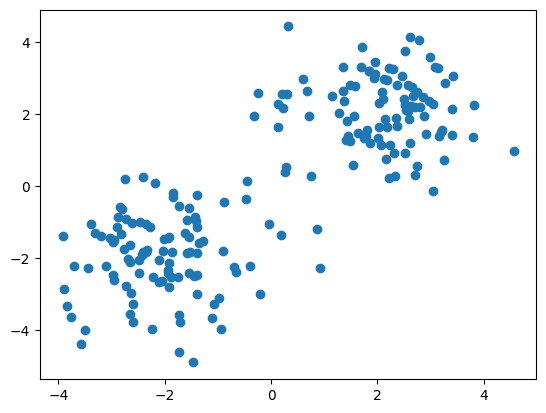

In [17]:


data = make_blobs(200, centers=[[-2, -2], [2, 2]])
x, y = data
plt.scatter(x[:, 0], x[:, 1])

In [18]:
batch_size = 20
max_steps = 2000
learning_rate = 0.01
x, y = torch.tensor(data[0]).float(), torch.tensor(data[1])
lr = LogitRegression(2)
lossi = []

for t in range(max_steps):
    ix = (t * batch_size) % len(x)
    xx = x[ix:ix + batch_size]
    yy = y[ix:ix + batch_size]  # (20)
    logits = lr(xx)  # (20,2)
    loss = F.cross_entropy(logits, yy)
    loss.backward()
    with torch.no_grad():
        for p in lr.parameters():
            p -= learning_rate * p.grad
            p.grad = None

    if t % 200 == 0:
        print(f'step{t}, loss{loss.item()}')
    lossi.append(loss.item())

step0, loss0.6793578863143921
step200, loss0.03450701758265495
step400, loss0.01650935225188732
step600, loss0.010551667772233486
step800, loss0.007615037262439728
step1000, loss0.005879480391740799
step1200, loss0.004739671945571899
step1400, loss0.003937453962862492
step1600, loss0.0033444359432905912
step1800, loss0.002889708150178194


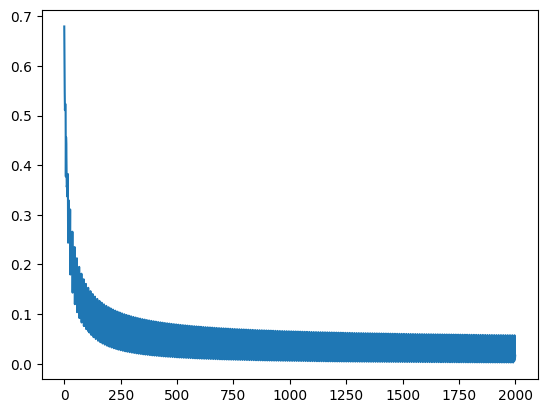

In [19]:
plt.plot(lossi)